In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data= pd.read_csv('/content/drive/My Drive/reviews.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We should first make the data usable by preprocessing


In [4]:
data.isnull().sum()

,0
review,0
sentiment,0


The dataset has no empty rows.

<Axes: xlabel='count', ylabel='sentiment'>

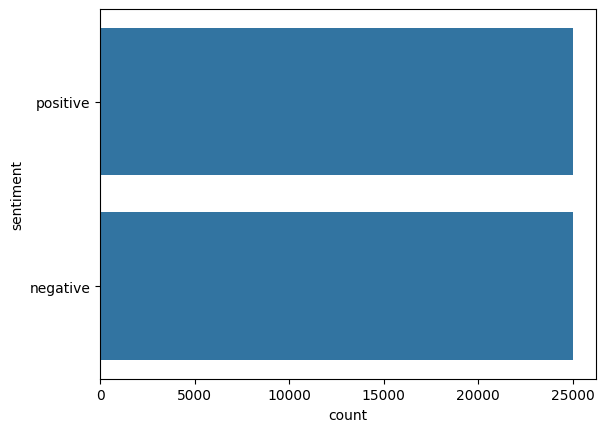

In [5]:
sns.countplot(data['sentiment'])

The reviews are evenly distributed between positive and negative.

We now remove punctuations for reducing noise in the text data.

In [6]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

data['review']= data['review'].apply(lambda x:remove_punctuation(x))
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production br br The filmin...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


Next we tokenize all the reviews.

In [8]:
def tokenization(text):
    tokens = re.split(r'\W+',text)
    return tokens
data['tokens']= data['review'].apply(lambda x: tokenization(x))

Now we remove the stopwords that add no information to the data to reduce noise.

In [9]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    output= [i for i in text if i.lower() not in stopwords]
    return output

data['tokens']= data['tokens'].apply(lambda x:remove_stopwords(x))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[One, reviewers, mentioned, watching, 1, Oz, e..."
1,A wonderful little production br br The filmin...,positive,"[wonderful, little, production, br, br, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically theres a family where a little boy J...,negative,"[Basically, theres, family, little, boy, Jake,..."
4,Petter Matteis Love in the Time of Money is a ...,positive,"[Petter, Matteis, Love, Time, Money, visually,..."


Lowercasing might make us lose stronger sentiments. Like "DO NOT BUY" is stronger that "Do not buy". For now we want to keep that information so we proceed without lowercasing.

Now we assign integers ids to tokens.

In [10]:
vocab = {'<PAD>': 0, '<UNK>': 1}    # 0 for padding and 1 for unknown words
idx = 2

for tokens in data['tokens']:
    for token in tokens:
        if token not in vocab:
            vocab[token] = idx
            idx += 1

data['IDs'] = data['tokens'].apply(lambda x: [vocab[token] for token in x])


In [11]:
data.head()

,review,sentiment,tokens,IDs
0,One of the other reviewers has mentioned that ...,positive,"[One, reviewers, mentioned, watching, 1, Oz, e...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,A wonderful little production br br The filmin...,positive,"[wonderful, little, production, br, br, filmin...","[149, 150, 151, 15, 15, 152, 153, 154, 155, 15..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su...","[220, 149, 221, 222, 223, 224, 225, 226, 227, ..."
3,Basically theres a family where a little boy J...,negative,"[Basically, theres, family, little, boy, Jake,...","[291, 292, 293, 150, 294, 295, 296, 292, 297, ..."
4,Petter Matteis Love in the Time of Money is a ...,positive,"[Petter, Matteis, Love, Time, Money, visually,...","[340, 341, 342, 343, 344, 345, 346, 314, 347, ..."


Next we add padding in each element in the IDs column to make sure they are the same length. '0' is preserved for padding. First we check the distribution of length of the IDs column.

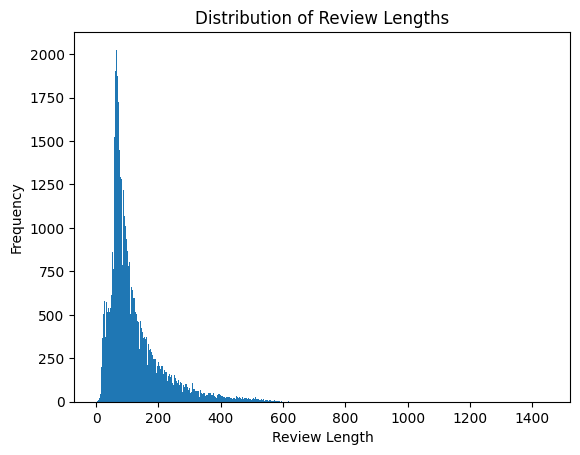

In [12]:
data['length'] = data['IDs'].apply(len)

plt.figure(55)
plt.hist(data['length'], bins=500)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

We reasonably take the max length to be 300. Almost all information will be retained.

In [13]:
data.drop(columns=['length'],inplace=True)   # Removed the length column.

In [14]:
MAX_LEN = 300       # Pad or truncate each list of input_ids to length MAX_LEN
def simple_pad(seq):
    seq = seq[:MAX_LEN]                          # Truncate
    seq += [0] * (MAX_LEN - len(seq))            # Pad with 0s
    return seq

data['Padded IDs'] = data['IDs'].apply(simple_pad)

In [15]:
data.head()

,review,sentiment,tokens,IDs,Padded IDs
0,One of the other reviewers has mentioned that ...,positive,"[One, reviewers, mentioned, watching, 1, Oz, e...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,A wonderful little production br br The filmin...,positive,"[wonderful, little, production, br, br, filmin...","[149, 150, 151, 15, 15, 152, 153, 154, 155, 15...","[149, 150, 151, 15, 15, 152, 153, 154, 155, 15..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su...","[220, 149, 221, 222, 223, 224, 225, 226, 227, ...","[220, 149, 221, 222, 223, 224, 225, 226, 227, ..."
3,Basically theres a family where a little boy J...,negative,"[Basically, theres, family, little, boy, Jake,...","[291, 292, 293, 150, 294, 295, 296, 292, 297, ...","[291, 292, 293, 150, 294, 295, 296, 292, 297, ..."
4,Petter Matteis Love in the Time of Money is a ...,positive,"[Petter, Matteis, Love, Time, Money, visually,...","[340, 341, 342, 343, 344, 345, 346, 314, 347, ...","[340, 341, 342, 343, 344, 345, 346, 314, 347, ..."


Now, we map the sentiments to integers 1 and 0 so that they are suitable for binary classification.

In [16]:
data['label'] = data['sentiment'].map({'positive': 1, 'negative': 0})
data.head()

,review,sentiment,tokens,IDs,Padded IDs,label
0,One of the other reviewers has mentioned that ...,positive,"[One, reviewers, mentioned, watching, 1, Oz, e...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",1
1,A wonderful little production br br The filmin...,positive,"[wonderful, little, production, br, br, filmin...","[149, 150, 151, 15, 15, 152, 153, 154, 155, 15...","[149, 150, 151, 15, 15, 152, 153, 154, 155, 15...",1
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su...","[220, 149, 221, 222, 223, 224, 225, 226, 227, ...","[220, 149, 221, 222, 223, 224, 225, 226, 227, ...",1
3,Basically theres a family where a little boy J...,negative,"[Basically, theres, family, little, boy, Jake,...","[291, 292, 293, 150, 294, 295, 296, 292, 297, ...","[291, 292, 293, 150, 294, 295, 296, 292, 297, ...",0
4,Petter Matteis Love in the Time of Money is a ...,positive,"[Petter, Matteis, Love, Time, Money, visually,...","[340, 341, 342, 343, 344, 345, 346, 314, 347, ...","[340, 341, 342, 343, 344, 345, 346, 314, 347, ...",1


In [17]:
x = torch.tensor(data['Padded IDs'].tolist(), dtype=torch.long)
y = torch.tensor(data['label'].values, dtype=torch.float)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1, random_state=42)


train_data= TensorDataset(x_train, y_train)
val_data= TensorDataset(x_val,y_val)
test_data= TensorDataset(x_test, y_test)

batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader  = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [22]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout_prob):
        super(SentimentLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)              #This turns the IDs to dense vectors
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout_prob, batch_first=True, bidirectional=True)       #This is the Long-Short-Term Memory (LSTM) layer
        self.dropout = nn.Dropout(dropout_prob)                           #This layer randormly drops neurons to avoid overfitting. A safe practice.
        self.fc = nn.Linear(hidden_dim*2, 1)                                # This maps the LSTM's output to a single value.

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return out.squeeze(1)                                           #This removes the redundant dimension to return a flat tensor of size (batch_size,)


In [23]:
vocab_size = len(vocab) + 2  # +2 for padding index 0 and unknown index 1
embed_dim = 100
hidden_dim = 128
num_layers = 2
dropout_prob = 0.4

model = SentimentLSTM(vocab_size, embed_dim, hidden_dim, num_layers, dropout_prob)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SentimentLSTM(
  (embedding): Embedding(212739, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=.5*1e-5)

In [25]:
epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, epochs + 1):

    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        preds = torch.round(torch.sigmoid(outputs))                   # Getting binary predictions by rounding off the sigmoid output
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = train_loss / total
    train_accuracy = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            preds = torch.round(torch.sigmoid(outputs))                  # Getting binary predictions by rounding off the sigmoid output
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / total
    val_accuracy = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch}/{epochs} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10 - Train Loss: 0.6936 - Train Accuracy: 0.5034 - Val Loss: 0.6928 - Val Accuracy: 0.5112
Epoch 2/10 - Train Loss: 0.6930 - Train Accuracy: 0.4993 - Val Loss: 0.6931 - Val Accuracy: 0.5112
Epoch 3/10 - Train Loss: 0.6903 - Train Accuracy: 0.5142 - Val Loss: 0.6931 - Val Accuracy: 0.5115
Epoch 4/10 - Train Loss: 0.6750 - Train Accuracy: 0.5218 - Val Loss: 0.7028 - Val Accuracy: 0.4978
Epoch 5/10 - Train Loss: 0.6608 - Train Accuracy: 0.5307 - Val Loss: 0.7130 - Val Accuracy: 0.5140
Epoch 6/10 - Train Loss: 0.6666 - Train Accuracy: 0.5564 - Val Loss: 0.7118 - Val Accuracy: 0.5310
Epoch 7/10 - Train Loss: 0.6431 - Train Accuracy: 0.6111 - Val Loss: 0.6474 - Val Accuracy: 0.6385
Epoch 8/10 - Train Loss: 0.4891 - Train Accuracy: 0.7865 - Val Loss: 0.5578 - Val Accuracy: 0.7195
Epoch 9/10 - Train Loss: 0.3520 - Train Accuracy: 0.8567 - Val Loss: 0.3503 - Val Accuracy: 0.8600
Epoch 10/10 - Train Loss: 0.1935 - Train Accuracy: 0.9297 - Val Loss: 0.3545 - Val Accuracy: 0.8562


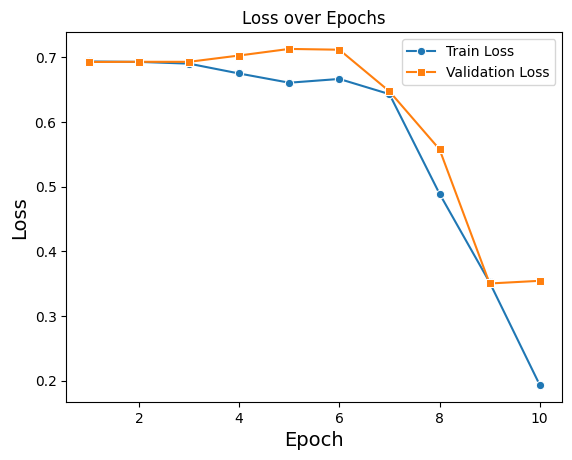

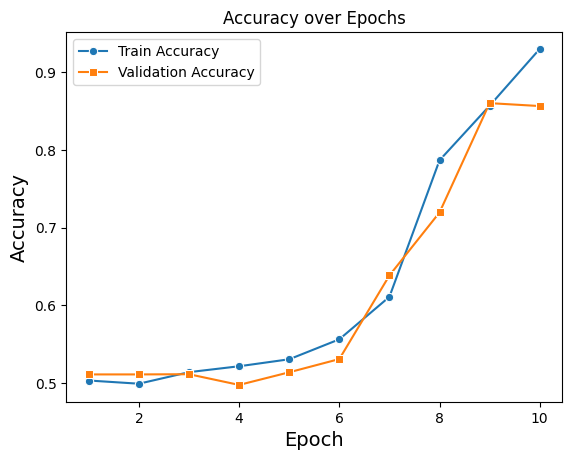

In [26]:

epochs = range(1, 11)


plt.figure(1)
sns.lineplot(x=epochs, y=train_losses, marker='o', label='Train Loss')
sns.lineplot(x=epochs, y=val_losses, marker='s', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.figure(2)
sns.lineplot(x=epochs, y=train_accuracies, marker='o', label='Train Accuracy')
sns.lineplot(x=epochs, y=val_accuracies, marker='s', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()



Test Loss: 0.3465 - Test Accuracy: 0.8586


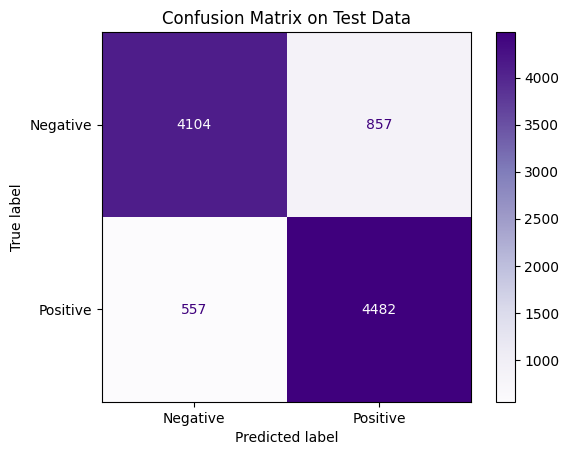

In [53]:
model.eval()
test_loss = 0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.round(torch.sigmoid(outputs))  # Getting binary predictions by rounding off the sigmoid output
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f"\nTest Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix on Test Data")
plt.show()

Now, we save the model and the model weights only separately for future references and usage.

In [28]:
torch.save(model, "sentiment_model.pth")
torch.save(model.state_dict(), "sentiment_model_weights.pth")

from google.colab import files

files.download("sentiment_model.pth")

files.download("sentiment_model_weights.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now that the training is done and the model is performing well, with 85.86% accuracy( After doing the following changes) on test data, we streamline the process using our trained model including the preprocessing by defining a function that predicts sentiments from input texts. At this point, we go back and include unknown, \<UNK> in our dictionary so that if the new review has a new word, it's assigned ID 1.

In [33]:
def predict_sentiment(text,model,vocab,device):

  text = "".join([char for char in text if char not in string.punctuation])
  tokens = re.split(r'\W+', text)
  stopwords = nltk.corpus.stopwords.words('english')
  tokens = [word for word in tokens if word.lower() not in stopwords and word != '']
  input_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
  padded = simple_pad(input_ids)
  input_tensor = torch.tensor([padded], dtype=torch.long).to(device)

  with torch.no_grad():
      output = model(input_tensor)
      prob = torch.sigmoid(output).item()

  sentiment = "Positive" if prob >= 0.5 else "Negative"
  return sentiment, prob

In [36]:
text_1="This movie was so bad that I felt like vomiting. I don't recommend this movie at all. WASTAGE of money"

predict_sentiment(text_1,model,vocab,device)

('Negative', 0.03203878551721573)

In [37]:
text_2='The movie was outstanding. Great storytelling and beautiful work of cameras. An exquisite piece of art.'
predict_sentiment(text_2,model,vocab,device)

('Positive', 0.9472779035568237)

__We see that our model is working very well when tested against my own reviews!__

__Model Architechture:__

1. Embedding layer with input as the vocabulary size and output as the embedding dimension = 100.

2. Bidirectional LSTM with input of the embeddings and output as hidden states. Hidden layer dimension was 128 and number of LSTM layers was 2. Dropout was added between the LSTM layers.

3. Dropout layer that was applied again to the last LSTM layer to prevent overfitting.

4. Linear layer that connected all the LSTM outputs to a single value expressing the sentiment.


Loss function: BCEWithLogitsLoss() that applied Sigmoid to the output of the Linear layer.

Optimizer: Adam with learning rate = 0.001 and weight decay= .5e-5

Batch size was 64.



__Problems Faced:__

1. Stuck at 50% accuracy: The model was for some reason stuck at 50% accuracy which means it was just guessing randomly. Switching from nn.BCELoss() with sigmoid in model to nn.BCEWithLogitsLoss() with no sigmoid inside the model fixed this.

2. Model training too slowly: Fixed by adjusting the learning rate, which then brought in overfitting.

3. Overfitting: The model was initially overfitting and the validation accuracy was dropping after a few epochs as the training accuracy was increasing. It was fixed by using L2 regularization by introducing weight_decay in the learning rate which after some experimentation, was fixed to be 0.5e-5.

4. Unknown words: For the model to be usable for new reviews, unknown words needed an ID which was fixed to be 1 later.

5. Not a problem, but bidirectional LSTM was used later for better contextual understanding as it takes into account sequence in both directions.